In this notebook, we present a demo of the Segmentation-Guided CTC (SG-CTC) loss function.
The objectif of this notebook is to provide a technical example of how to use the SG-CTC loss function.
We compare the SG-CTC loss function with the classic CTC loss function.
To make a basic example, we use the MNIST dataset and we create an artifical sequence of data. Each sequence is composed of 20 numbers between 0 and 9. The goal is to predict the 20 numbers of the sequence.
We used a simple 3D CNN to predict the sequence.

We hope that this notebook will help you to understand how to use the SG-CTC loss function.

# Import libraries
we used tensorflow for this example, but the loss can be translated to pytorch. Our SG*CTC version is based on a pytorch implementation.

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
# remove warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)


Let's load MNIST and ensure that the data are in the correct format.

In [2]:
### import data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(
    path='mnist.npz',
)
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

# Create the articifial sequences from MNIST
we define the number of number per sequence, and the number of images to produce.
Concretely, we concatenate 20 images of MNIST, creating a long image of 20*28 pixels width, and 28 pixels height.
Then, we split the image into 80 sub-images, leading to 80 images of 7(width)*28(height) pixels.


In [3]:
nbElemPerSeq = 20
nbForInput = 80

def createArtficial(set, size):
    set_seq = tf.cast(tf.reshape(set, shape=[size // nbElemPerSeq, nbElemPerSeq, 28, 28, 1]), tf.float32)
    set_seq = tf.transpose(set_seq, [0, 2, 1, 3, 4])  #[size//nbElemPerSeq,28,nbElemPerSeq,28,1]
    set_seq = tf.reshape(set_seq, [size // nbElemPerSeq, 28, nbElemPerSeq * 28, 1])
    # set_seq = tf.pad(set_seq, [[0, 0], [0, 0], [0, 0], [0, 0]])
    set_seq = tf.reshape(set_seq, [size // nbElemPerSeq, 28, nbForInput, tf.shape(set_seq)[2] // nbForInput, 1])
    set_seq = tf.transpose(set_seq, [0, 2, 1, 3, 4])
    return set_seq


x_train_seq = createArtficial(x_train, 60000)
x_test_seq = createArtficial(x_test, 10000)


The data are ready, but lets update the labels to match the new data.
Now, one label is the sequence of 20 numbers, and not a single number.
we will reorganize the labels in the same way as the data.
We reserve the label 0 for the blank label, so we add 1 to all labels.


In [4]:
y_train_seq = tf.reshape(y_train, shape=[60000 // nbElemPerSeq, nbElemPerSeq])
y_test_seq = tf.reshape(y_test, shape=[10000 // nbElemPerSeq, nbElemPerSeq])

# we add 1 to the labels because 0 is reserved for the blank label
y_train_seq = tf.cast(y_train_seq, tf.int32)+1
y_test_seq = tf.cast(y_test_seq, tf.int32)+1


To finish with the label, we need to know the start and end frame of each label.
This is one of the difference between the CTC and the SG-CTC loss function, the SG-CTC loss function needs to know the start and end frame of each label (during the training).
Note that if at the beginning you don't know the start and end frame of each label, you can put the same start and end frame for all labels, which are the first and last frame of the sequence, this will be equivalent to the CTC loss function. However, these could be updated during the training, by producing kind of "pseudo-labels".
Here, we know the start and end frame of each label, so we will use it.
We will put the start/end frames index into the label tensor.

In [5]:


nbOfFramesPerLabel = (nbForInput)/nbElemPerSeq
# first label is between 0 and nbOfFramesPerLabel, second between nbOfFramesPerLabel and 2*nbOfFramesPerLabel, etc
ranging = tf.range(nbElemPerSeq, dtype=tf.float32)
# get the tensor of the start frame of each label
startFrame = ranging * (nbOfFramesPerLabel) # shape is [nbForInput]
# get the tensor of the end frame of each label
endFrame = (ranging + 1) * (nbOfFramesPerLabel) # shape is [nbForInput]


concat = tf.concat([startFrame[ :,tf.newaxis], endFrame[:,tf.newaxis]], axis=-1) # shape is [nbForInput,2]

#round the start and end frames
concat = tf.cast(tf.round(concat), tf.int32)
# repeat for all sequences, in the way we constructed the sequences, the start and end frames are the same for all sequences
concattrain = tf.repeat(concat[tf.newaxis], repeats=60000 // nbElemPerSeq, axis=0)
concattest = tf.repeat(concat[tf.newaxis], repeats=10000 // nbElemPerSeq, axis=0)

y_train_seq = y_train_seq[:, :, tf.newaxis]
y_test_seq = y_test_seq[:, :, tf.newaxis]

#concat to the y
y_train_seq = tf.concat([y_train_seq, concattrain], axis=-1)
y_test_seq = tf.concat([y_test_seq, concattest], axis=-1)
# y_train_seq shape is [60000//nbElemPerSeq,nbElemPerSeq,3], 3 for the label index, start and end frame indexes
# y_test_seq shape is [10000//nbElemPerSeq,nbElemPerSeq,3]


Now that the data are ready, we can create the tf.Dataset object

In [6]:


batch = 4
train_ds = tf.data.Dataset.from_tensor_slices((x_train_seq, y_train_seq))
train_ds = train_ds.shuffle(10000)
train_ds = train_ds.padded_batch(batch)
train_ds = train_ds.repeat()

test_ds = tf.data.Dataset.from_tensor_slices((x_test_seq, y_test_seq)).batch(batch)
a = next(iter(train_ds))
print(tf.shape(a[0]))
print(tf.shape(a[1]))

tf.Tensor([ 4 80 28  7  1], shape=(5,), dtype=int32)
tf.Tensor([ 4 20  3], shape=(3,), dtype=int32)


Lets visualize an example of the generated data with labels (on top)

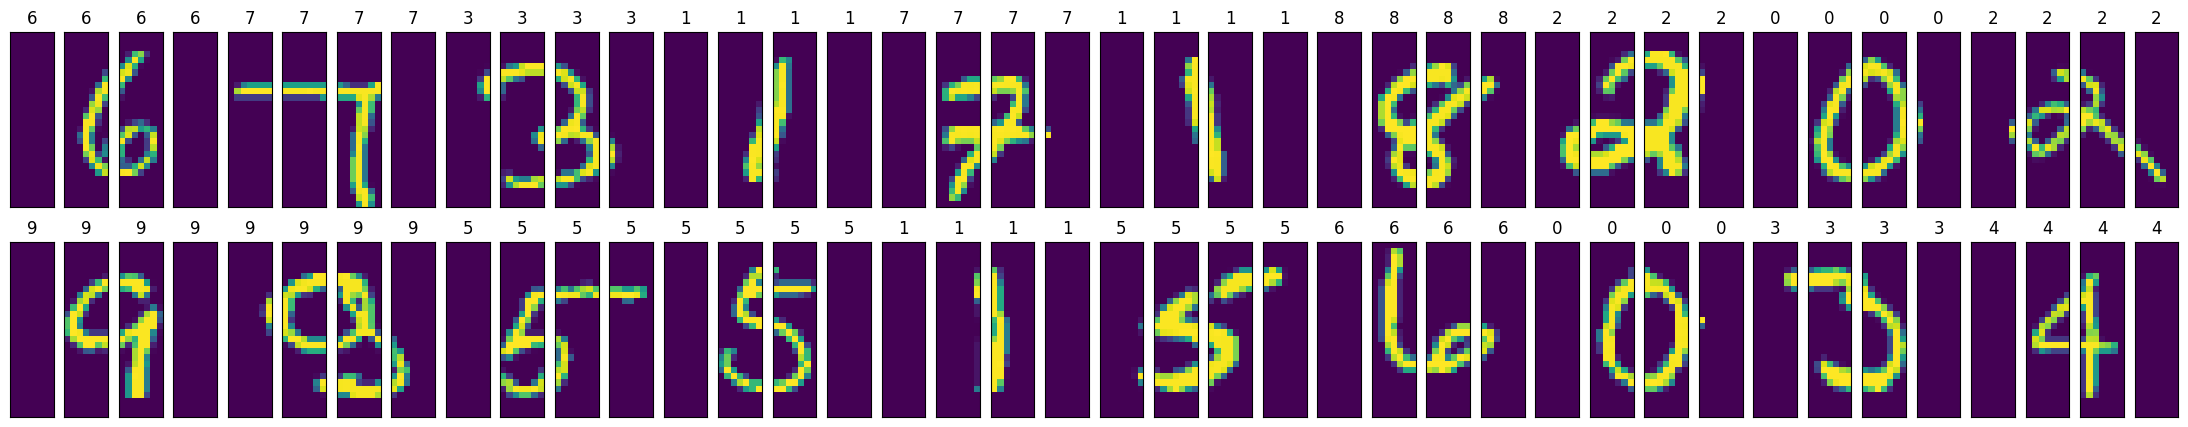

In [7]:
sample = 7
_, axs = plt.subplots(2, nbForInput // 2, figsize=(28, 5))
axs = axs.flatten()
currentframe=0
currentId=0
for img, ax in zip(x_test_seq[sample, :], axs):
    ax.imshow(img)
    # for the correponding label using start and end frames
    if currentframe>=y_test_seq[sample,currentId,2]:
        currentId+=1
    currentframe+=1
    ax.set_title(y_test_seq[sample,currentId,0].numpy()-1)
    #remove x and yticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


# Definition of some metrics
We define a metric to analyse the purcent of blank label per sequence, and the purcent of correct prediction (one to one prediction).

In [8]:
### Define the evaluate/stats
def EvalAndStat(model, test_seqs, labels_test_seqs):
    PurcentOfBlankPerSeq = 0
    numberofSequence = len(test_seqs)

    correctPred = 0
    correctLen = 0

    for id, sample in enumerate(test_seqs):
        results = model(sample[tf.newaxis]) # [1,nbForInput,nbClass+1]
        # results = tf.squeeze(results, axis=0)
        resultsTransposed = tf.transpose(results, [1, 0, 2])
        resultBrut = tf.argmax(resultsTransposed, axis=-1).numpy()
        PurcentOfBlankPerSeq += len(tf.where(resultBrut == 0)) / len(resultBrut)
        # print(PurcentOfBlankPerSeq)
        # print(resultBrut)
        label = labels_test_seqs[id][:, 0]
        res = tf.nn.ctc_greedy_decoder(resultsTransposed, [nbForInput] * 1, blank_index=0)[0][0].values.numpy()
        # print(res)
        # print(label)
        # print(tf.where(res==label))
        if len(res) != len(label):
            if len(res) < len(label):
                res = tf.pad(res, [[len(label) - len(res), 0]])
            else:
                label = tf.pad(label, [[len(res) - len(label), 0]])
            # print("corrected")
            # print(len(res))
            # print(len(label))
        correctPred += len(tf.where(tf.cast(res, tf.int64) == tf.cast(label, tf.int64)))
        correctLen += len(res)
        # break
    print("Purcent of blank per seq : ", PurcentOfBlankPerSeq / numberofSequence * 100)
    print("ExactPredictions : ", correctPred / correctLen)
    return PurcentOfBlankPerSeq / numberofSequence * 100, correctPred / correctLen


# Create the model
We define a simple model which will give the sequence of predictions for each input sequence, the 3D CNN have "temporal" (axis of images) context and extract features across the 3 dimensions.
It has 5 convolutions and 5 maxpooling, followed by a flatten and a dense layer.
32 filters are used for each convolution, and the kernel size is 3x3x3.
128 neurons are used for the dense layers.
The final output is nbClass+1, because we add a blank label (dedicated to the first neuron, id 0).
The output does not have any activation (linear), this is necessary for the CTC losses. => this is very important, otherwise the model will not learn correctly.

In [9]:


nbClass=10
##Create simple model
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        # inputs = tf.keras.Input(shape=(nbElemPerSeq,28, 28,1))
        self.convs = [tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', input_shape=(nbElemPerSeq, 28, 12, 1),
                                    padding="same")] +\
                     [tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding="same") for _ in range(4)]

        self.maxpools = [tf.keras.layers.MaxPooling3D((1, 2, 2), padding="same") for _ in range(5)]
        self.flat = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(128, activation='relu')
        self.dense3 = tf.keras.layers.Dense(nbClass + 1, activation="linear")  #batch, x,y, features
        # self.reluShifted = tf.keras.layers.ReLU(threshold=1e-5)
    # self.logSoftmax = layers.Softmax()


    def call(self, x):
        for id, conv in enumerate(self.convs):
            x = conv(x)
            x = self.maxpools[id](x)
        x = self.flat(x)  #32,50,-1
        x = self.dense1(x)  #32,50,128
        x = self.dense2(x)  #32,50,128
        x = self.dense3(x)  #32,50,nbClass+1
        return x


model = MyModel()
out = model(a[0])
print(tf.shape(out))


tf.Tensor([ 4 80 11], shape=(3,), dtype=int32)


# Define the losses
we define the two functions that will be used for the training.
The first one is the simple CTC loss, the second one is the segmentation guided CTC loss (it calls the function in the file ctc_normal_customRec_tf.py).

In [10]:
from Tools.LossesAndMetrics.ctc_normal_customRec_tf import ctc_loss_log_custom_prior_with_recMatrix_computation # our SG guided ctc + weighted label prior (psi)


def lossSimpleCTC(true,pred):
    shapeOfTrue = tf.shape(true) #[batch,nbElemPerSeq,3]
    shapeOfPred = tf.shape(pred) #[batch,nbElemForInput,11]
    return tf.nn.ctc_loss(true[:,:,0], # the classic ctc does not need the start and end frames.
                          pred,
                          label_length=tf.repeat(shapeOfTrue[1],repeats = shapeOfTrue[0]),
                          logit_length=tf.repeat(shapeOfPred[1],repeats =shapeOfTrue[0]),
                        logits_time_major=False,blank_index=0)


def lossSegmentationGuidedAndLabelPrior(true,pred,psi=0):
    shapeOfTrue = tf.shape(true) #[batch,nbElemPerSeq]
    shapeOfPred = tf.shape(pred) #[batch,nbElemForInput,11]  # here the length of the sequence is always nbForInput, just repeat itf or each batch, but the loss support variable length

    nbForInputPerBatch = tf.repeat(shapeOfPred[1],repeats = tf.shape(true)[0],axis=0)[:,tf.newaxis]
    # the number of token per sequence is always the same here : nbElemPerSeq, but the loss support variable length
    nbElemPerSeqPerBatch = tf.repeat(shapeOfTrue[1],repeats = tf.shape(true)[0],axis=0)[:,tf.newaxis]
    # these dimensions should be [batch,1] (the loss support variable length per seq)

    # warning, pred and true are inverted in the function definition (in opposition to the classic ctc loss), the predictions are the first argument, and the labels are the second argument.
    return ctc_loss_log_custom_prior_with_recMatrix_computation(pred,true,nbForInputPerBatch,nbElemPerSeqPerBatch,weightPrior=psi,doSSG=True)

# Define the optimizer and train the model

## Classic CTC Training Version


In [11]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001,    name='Adam')
# lengthLabels = tf.convert_to_tensor([nbElemPerSeq]*batch)[:,tf.newaxis]
# nbForInputLength = tf.convert_to_tensor([nbForInput]*batch)[:,tf.newaxis]
modelNormal = MyModel()

modelNormal.compile(optimizer=adam,
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              # loss=[lambda true,pred:lossSegmentationGuidedAndLabelPrior(true,pred,psi=0)],
              loss=[lossSimpleCTC],              # loss=lambda true,pred:ctc_ent_loss_log(pred,true+1,nbElemPerSeq),
              metrics=[])
checkpoint_filepath = ".data/models3/simpleCTC"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


The training using the classic CTC loss is generally faster than the training using the segmentation guided CTC loss, because the classic one is optimized and included in tensorflow.
However sometimes the pruning simplifies the training and the convergence of the segmentation guided CTC loss is faster, the computation can also be faster (a lot of zeros).

In [12]:

# historyNormalCTC = modelNormal.fit(train_ds, epochs=10,callbacks=[model_checkpoint_callback],steps_per_epoch=60000/nbForInput/batch,
#                     validation_data=test_ds,verbose=2)
#Epoch 10/10
#187/187 - 15s - loss: 1.3628 - val_loss: 1.5935 - 15s/epoch - 82ms/step

# load the best model
modelNormal = tf.keras.models.load_model(checkpoint_filepath,compile=False)

The classic CTC is producing a lot of blanks: 75% of the tokens are predicted as blanks.

In [13]:
blanksCTCnormal,scoreCTCnormal = EvalAndStat(modelNormal,x_test_seq,y_test_seq)



Purcent of blank per seq :  74.995
ExactPredictions :  0.9793


Lets observe the predictions on one sequence. -1 is the blank. We observe genearrly only one non-blank token per number

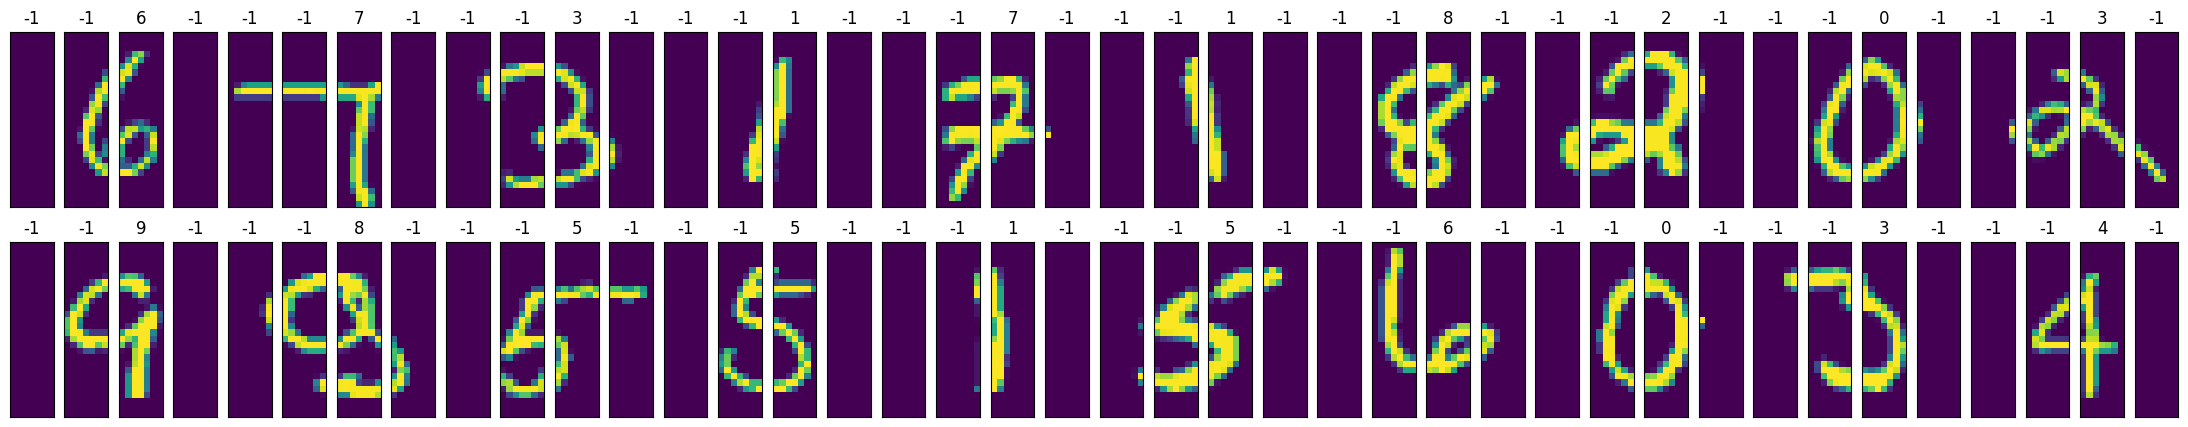

In [14]:
# plot the result on one sequence
sample = 7
_, axs = plt.subplots(2, nbForInput // 2, figsize=(28, 5))
axs = axs.flatten()
currentframe=0
currentId=0

#infer the sample
out = modelNormal(x_test_seq[sample, tf.newaxis])[0]
out = tf.argmax(out, axis=-1)

for img, ax in zip(x_test_seq[sample, :], axs):
    ax.imshow(img)
    # for the correponding label using start and end frames
    ax.set_title(out[currentframe].numpy()-1)
    currentframe+=1
    #remove x and yticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# With Guided and label prior

We define 6 models with different values of the label prior weight (0,0.2,0.4,0.6,0.8,1).

In [15]:
# lengthLabels = tf.convert_to_tensor([nbElemPerSeq]*batch)[:,tf.newaxis]
# nbForInputLength = tf.convert_to_tensor([nbForInput]*batch)[:,tf.newaxis]
modelsGuided = [MyModel() for i in range(6)]
for id, mod in enumerate(modelsGuided):
    mod.compile(optimizer=adam,
                  loss=[lambda true,pred:lossSegmentationGuidedAndLabelPrior(true,pred,psi=id*0.2)],
                  # loss=lambda true,pred:ctc_ent_loss_log(pred,true+1,nbElemPerSeq),
                  metrics=[])


We can observe that the loss can be negative using the weighted label prior, that is totally normal and it's not a problem for the training.

In [16]:
histories = []

# for id, mod in enumerate(modelsGuided):
#     checkpoint_filepath = f".data/models/guidedCTC{id*0.2}"
#     model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#         filepath=checkpoint_filepath,
#         monitor='val_loss',
#         mode='min',
#         save_best_only=True)#     print("Training model with id ",id,"psi = ",id*0.2)
#     histories.append(
#           mod.fit(train_ds, epochs=10,callbacks=[model_checkpoint_callback],steps_per_epoch=60000/nbForInput/batch,
#                 validation_data=test_ds,verbose=2))

#psi = 0
#Epoch 10/10
#187/187 - 13s - loss: 1.9981 - val_loss: 2.3827 - 13s/epoch - 69ms/step

#psi = 0.2
#Epoch 10/10
#187/187 - 13s - loss: -1.6657e+01 - val_loss: -1.6620e+01 - 13s/epoch - 70ms/step

#psi = 0.4
#Epoch 10/10
#187/187 - 14s - loss: -6.0287e+01 - val_loss: -6.1417e+01 - 14s/epoch - 76ms/step

#psi = 0.6
#Epoch 10/10
#187/187 - 14s - loss: -1.0067e+02 - val_loss: -1.0061e+02 - 14s/epoch - 74ms/step

#psi = 0.8
#Epoch 10/10
#187/187 - 13s - loss: -1.3638e+02 - val_loss: -1.3599e+02 - 13s/epoch - 70ms/step

#psi = 1
#Epoch 10/10
#187/187 - 13s - loss: -1.7370e+02 - val_loss: -1.7291e+02 - 13s/epoch - 70ms/step



# load the models
modelsGuided2 = []
for id, mod in enumerate(modelsGuided):
    print("Loading model with id ",id,"psi = ",id*0.2)

    modt = tf.keras.models.load_model(f".data/models3/guidedCTC{id*0.2}",compile=False)
    modelsGuided2.append(modt)

modelsGuided = modelsGuided2

Loading model with id  0 psi =  0.0
Loading model with id  1 psi =  0.2
Loading model with id  2 psi =  0.4
Loading model with id  3 psi =  0.6000000000000001
Loading model with id  4 psi =  0.8
Loading model with id  5 psi =  1.0


# Evaluate the models
we observe now the amount of blanks and the scores for each model.
As expected, and as already observed in our paper, the blanks are significantly reduced with the weight of the label prior.
We observed in our paper a gain (of score and earliness) comparing to the normal CTC, here the difference is not significant. It's probably due to the fact that here the task is not causal, so the localization for the normal CTC is not a problem, moreover the labels are equally distributed in the sequence (1 labels for 3/4 frames), the task is easier.

--Eval model with id  0 psi =  0.0
Purcent of blank per seq :  74.96000000000002
ExactPredictions :  0.9808
--Eval model with id  1 psi =  0.2
Purcent of blank per seq :  58.3275
ExactPredictions :  0.9322709163346613
--Eval model with id  2 psi =  0.4
Purcent of blank per seq :  48.16
ExactPredictions :  0.9345273631840796
--Eval model with id  3 psi =  0.6000000000000001
Purcent of blank per seq :  30.587499999999938
ExactPredictions :  0.8253065228052967
--Eval model with id  4 psi =  0.8
Purcent of blank per seq :  12.542500000000006
ExactPredictions :  0.8287495053423031
--Eval model with id  5 psi =  1.0
Purcent of blank per seq :  9.442499999999992
ExactPredictions :  0.8595538886695618


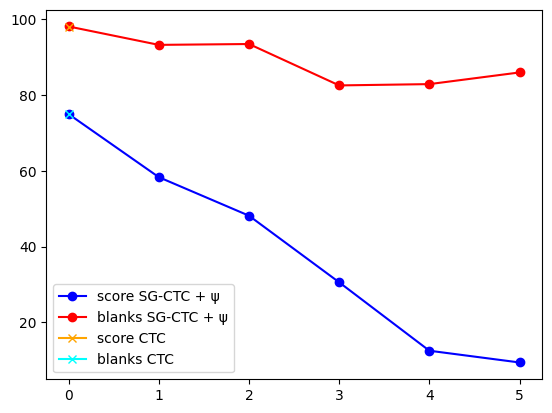

In [17]:
blanks = []
scores = []
for id, mod in enumerate(modelsGuided):
    print("--Eval model with id ",id,"psi = ",id*0.2)
    blank,score = EvalAndStat(mod,x_test_seq,y_test_seq)

    # plot the blanks score (y axis) for each psi (x axis)
    blanks.append(blank)
    scores.append(score*100)

#plot the result
plt.plot(blanks,marker='o',color='blue')
plt.plot(scores,marker='o',color='red')

#plot the normal CTC score and blank
plt.plot([0],[scoreCTCnormal*100],marker='x',color='orange')
plt.plot([0],[blanksCTCnormal],marker='x',color='cyan')

plt.legend(["score SG-CTC + ψ","blanks SG-CTC + ψ","score CTC","blanks CTC"])



A qualitative result is also presented, we can observe that the model with the highest weight have almost no blanks, and the model with the lowest weight have a lot of blanks.

Plot model with id  0 psi =  0.0


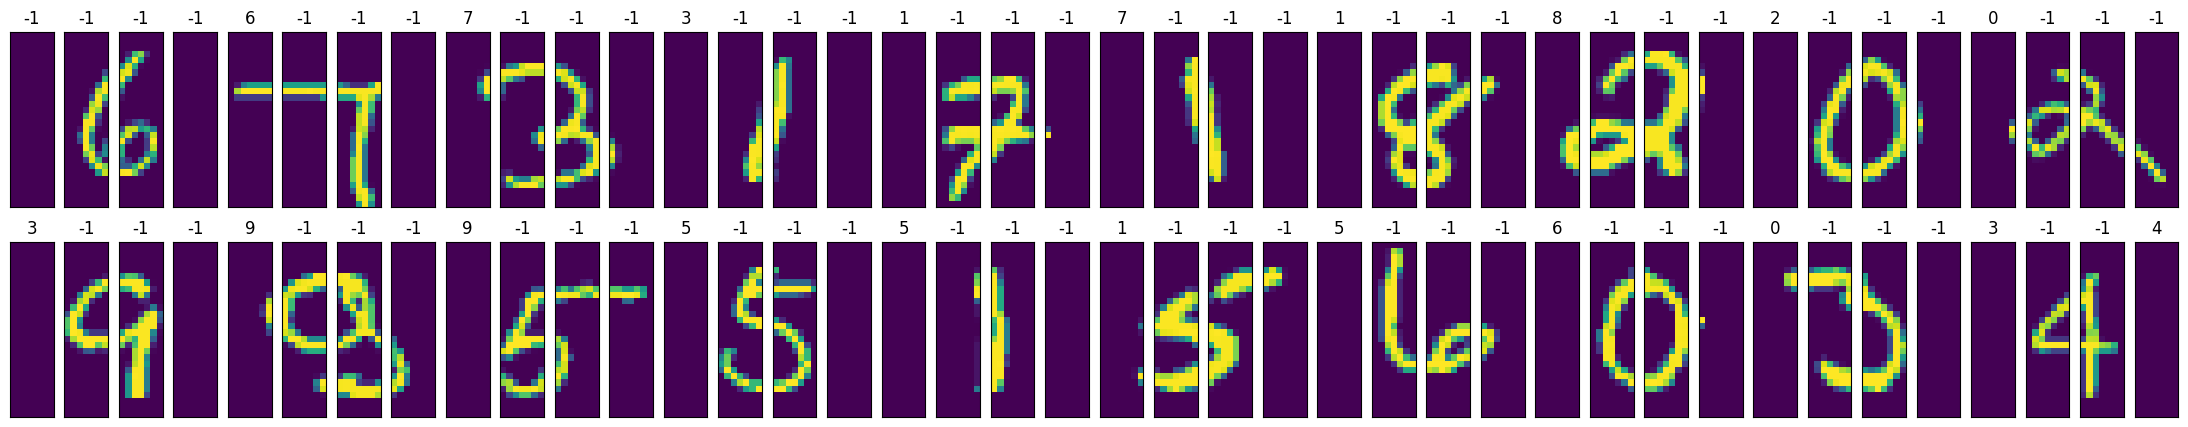

Plot model with id  1 psi =  0.2


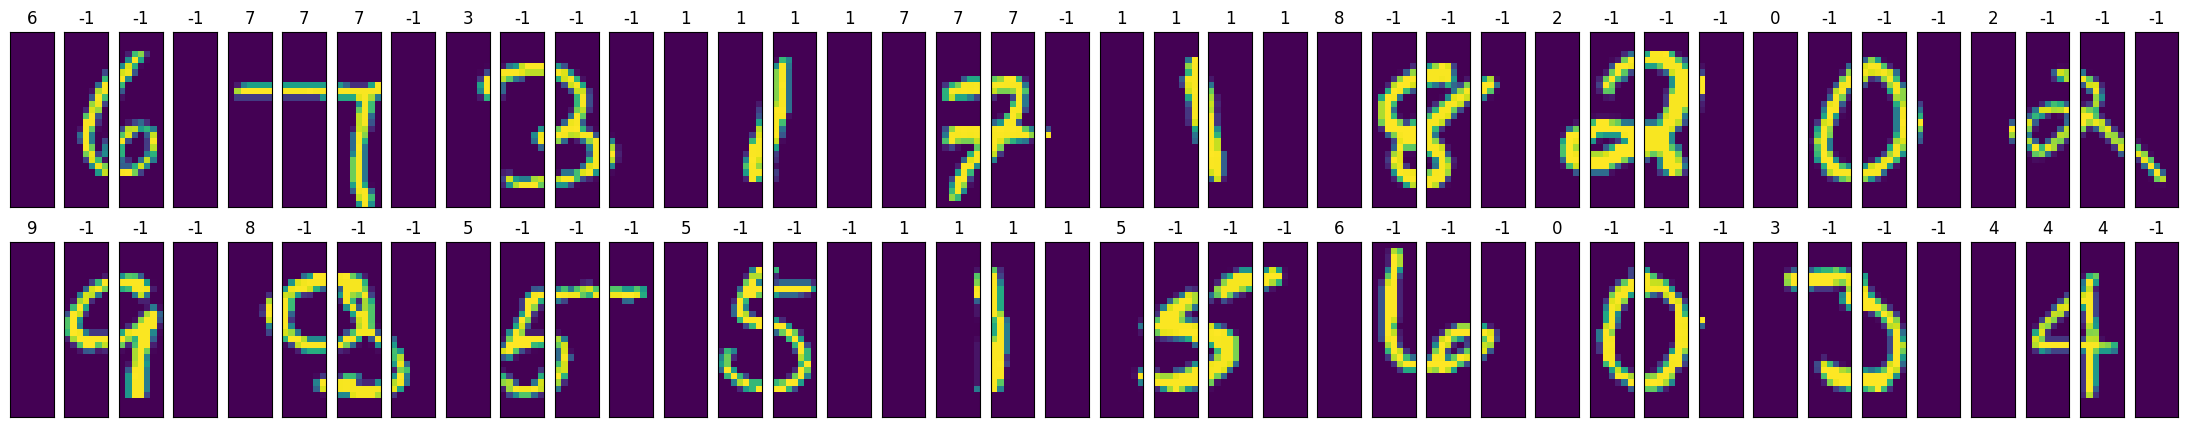

Plot model with id  2 psi =  0.4


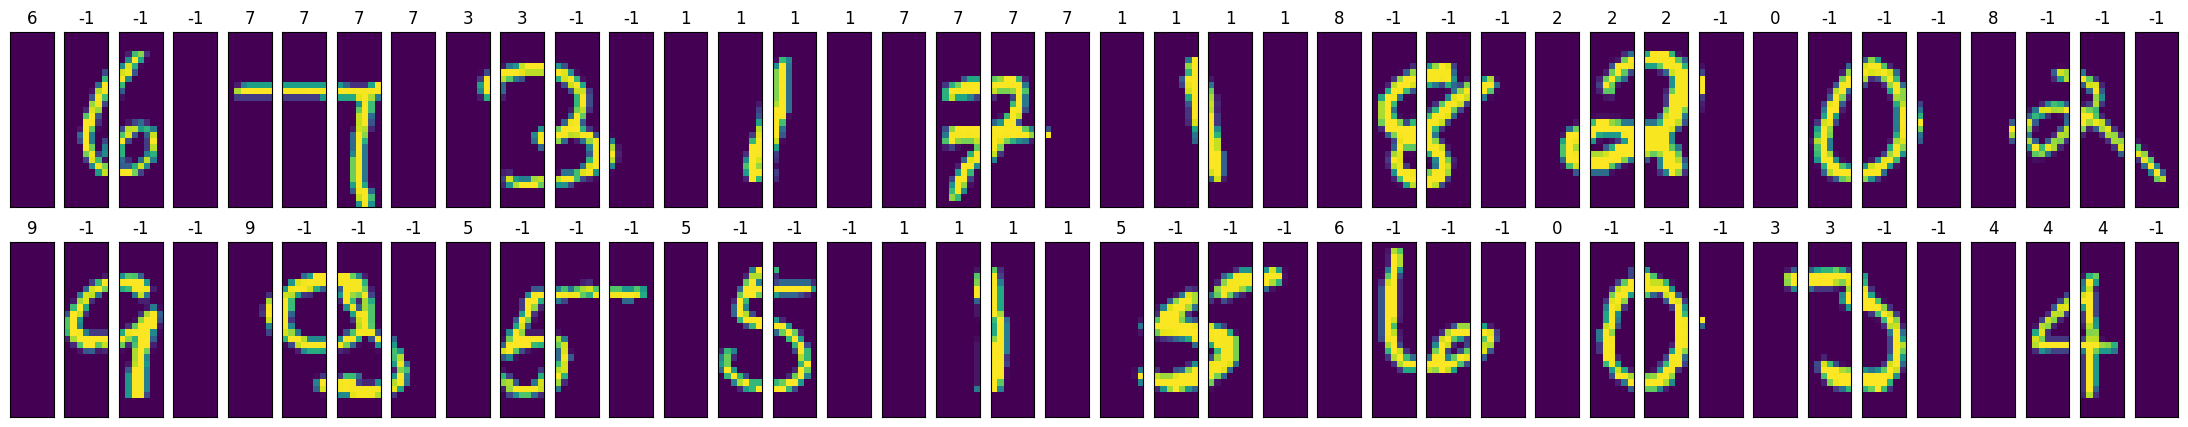

Plot model with id  3 psi =  0.6000000000000001


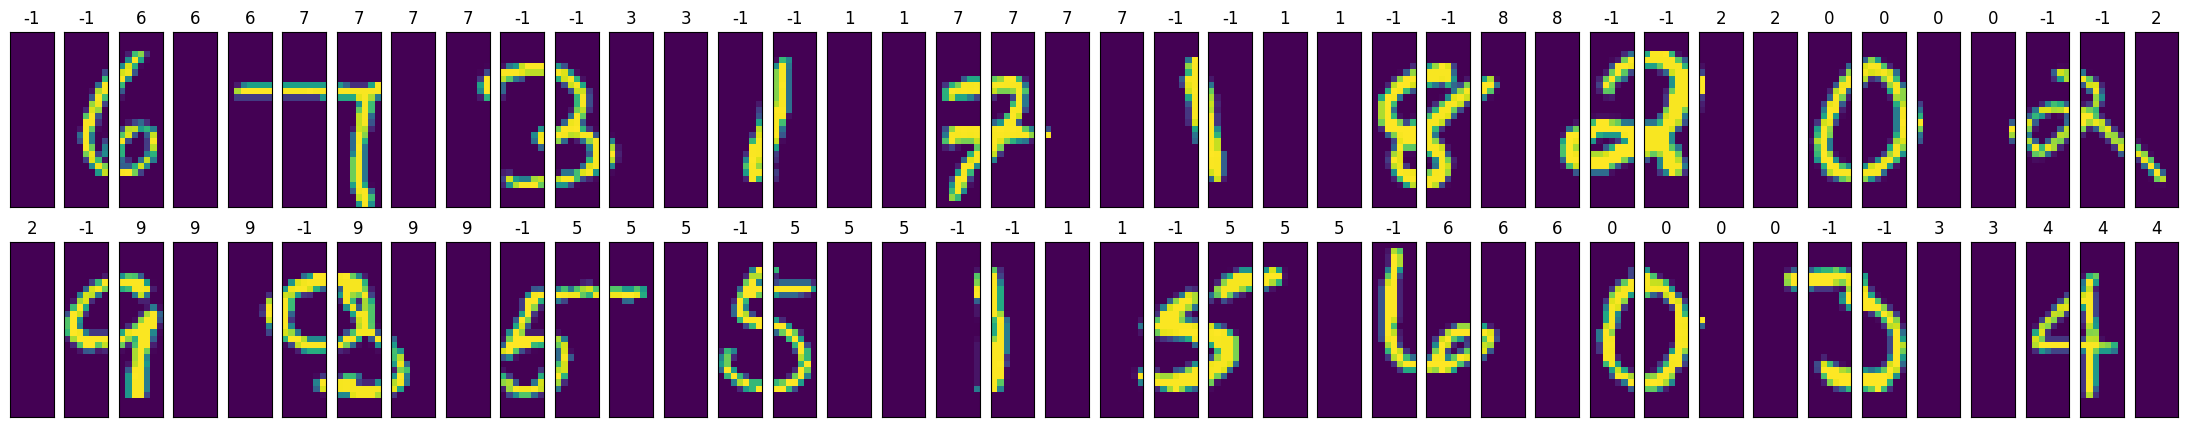

Plot model with id  4 psi =  0.8


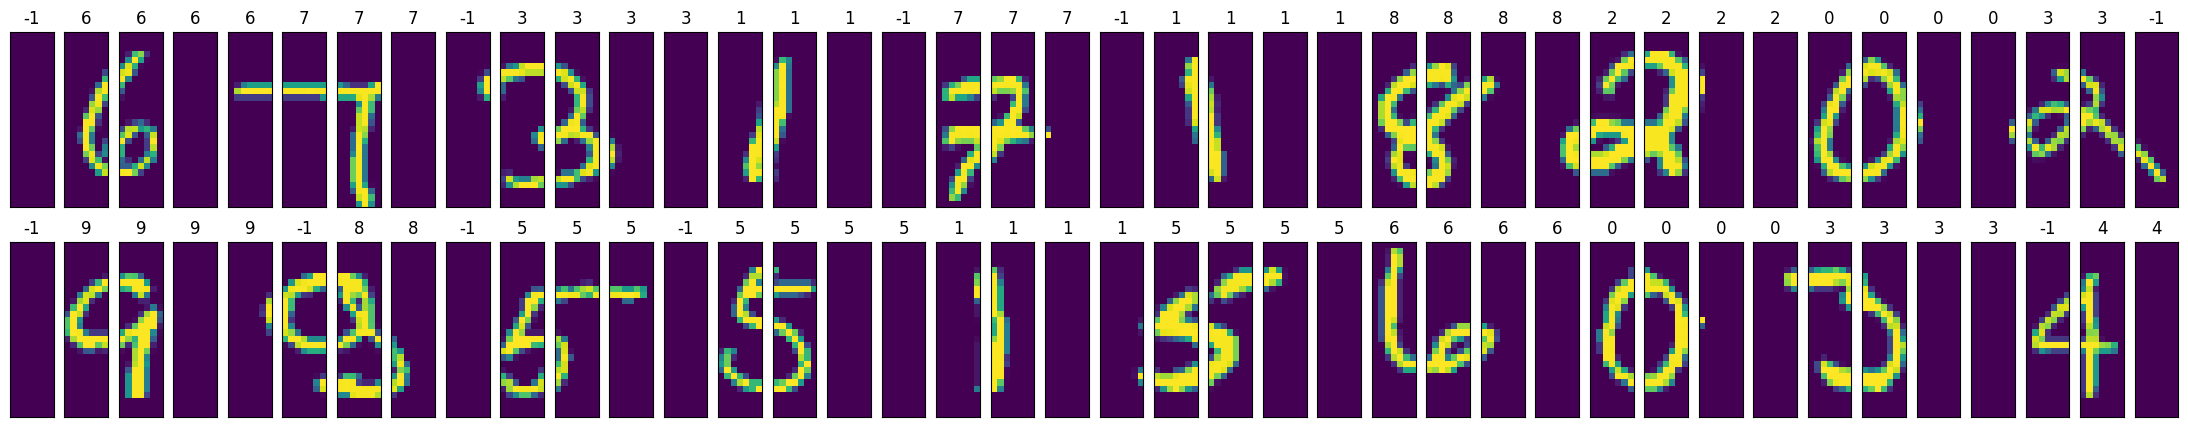

Plot model with id  5 psi =  1.0


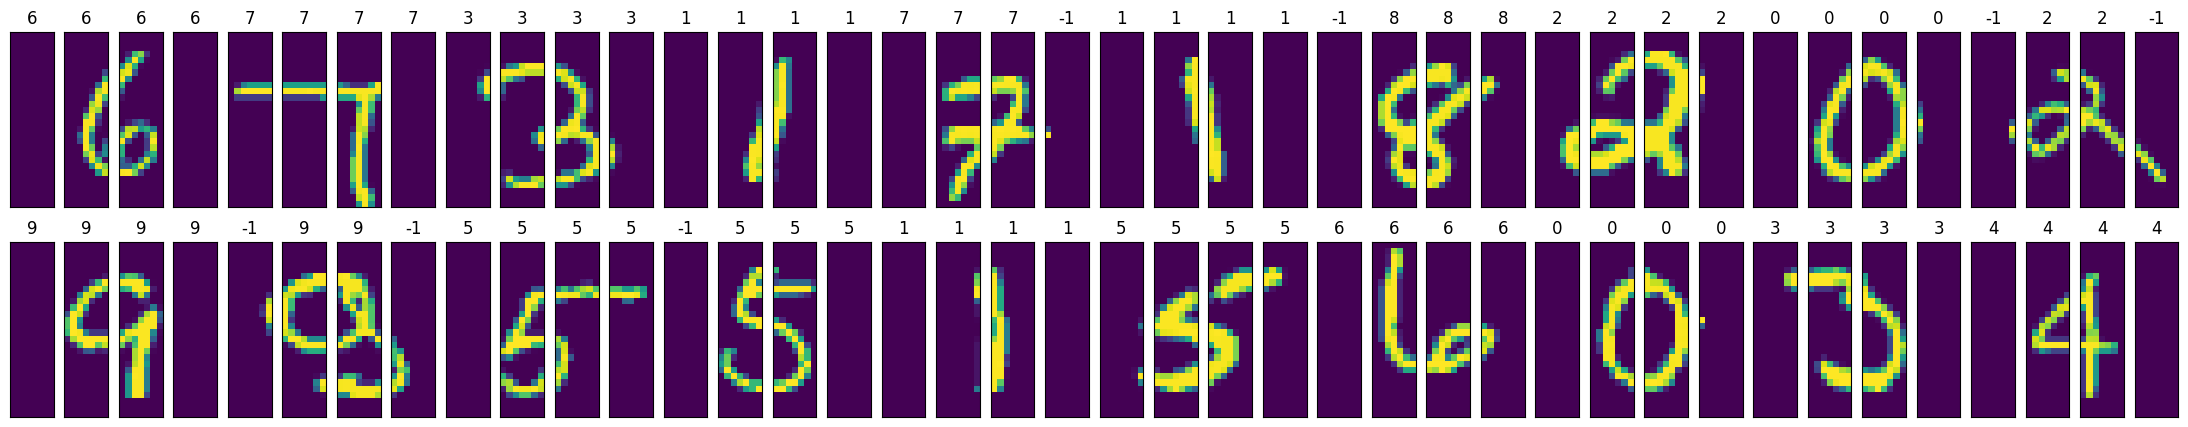

In [18]:
# plot the result on one sequence
for id, mod in enumerate(modelsGuided):
    print("Plot model with id ",id,"psi = ",id*0.2)
    sample = 7
    _, axs = plt.subplots(2, nbForInput // 2, figsize=(28, 5))
    axs = axs.flatten()
    currentframe=0
    currentId=0

    #infer the sample
    out = mod(x_test_seq[sample, tf.newaxis])[0]
    out = tf.argmax(out, axis=-1)

    for img, ax in zip(x_test_seq[sample, :], axs):
        ax.imshow(img)
        # for the correponding label using start and end frames
        ax.set_title(out[currentframe].numpy()-1)
        currentframe+=1
        #remove x and yticks
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()


# An overview of the recurrence matrix, the heart of the guided CTC implementation
The heart of the SG-CTC is the recurrence matrix. This matrix represents the possible graph transition.
In the normal CTC, the transitions are the same for each step, but in the SG-CTC, the transitions differents for each step.
lets take a look at the graph for a given label sequence : [1 8].


In [19]:
from Tools.LossesAndMetrics.ctc_normal_customRec_tf import compute_recurrence_Matrix_from_labels

#define the label with start/end
labels = [
    [1,2,7],
    [8,12,14],
]

Time = tf.constant(20)

# compute recurrence during preprocessing in pythonic way (optimal but optional)
from Tools.LossesAndMetrics.CustomRecurrenceMatrix import getCustomGraphMatrixFromBounds
m_cleaner = getCustomGraphMatrixFromBounds(list(labels), 20, True)

# compute recurrence during training in tensorflow way (in the loss, easiest)
seqLen = tf.convert_to_tensor(Time, dtype=tf.int32)
m_loss = compute_recurrence_Matrix_from_labels(tf.convert_to_tensor(labels)[tf.newaxis], seqLen, True)
print("Recurrence matrix for the labels: ",m_cleaner[:2])

Recurrence matrix for the labels:  [[[1 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 1 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]


This recurrent matrix give an idea, but is not easily readable, we can use the function exportGraphFromMatrix to export a graph from this matrix.
The score of the paths is computed from the top left node, to the the bottom right node.
So any path that goes from the top left to the bottom right is a valid path, otherwise it will not be counted in the score (multipled somewhere with 0).


 1 1 8 2 


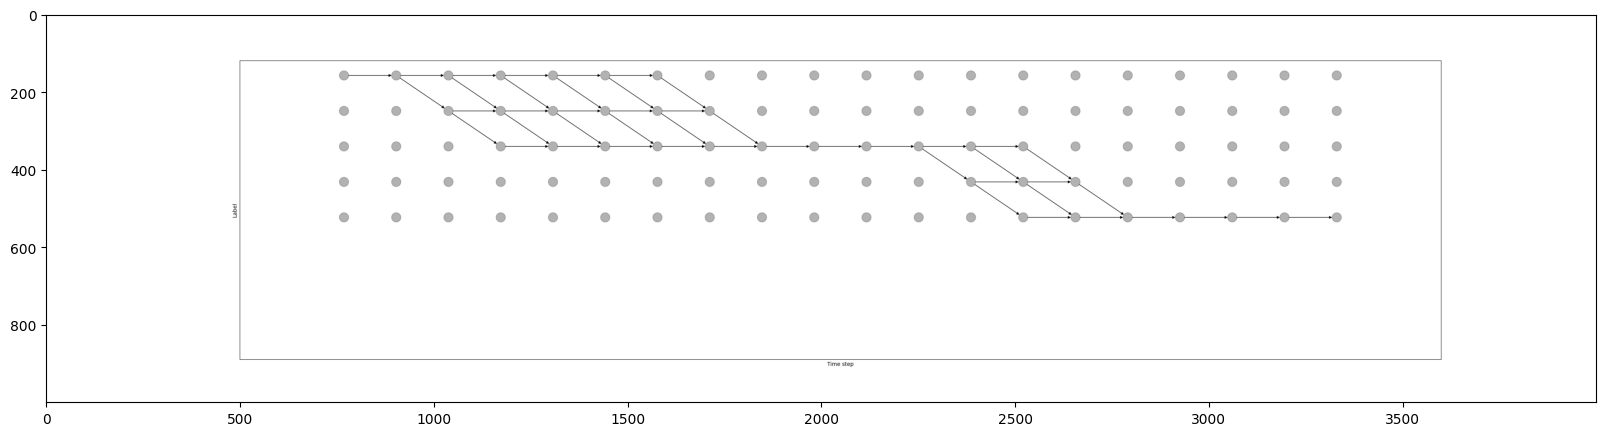

In [20]:

from Tools.LossesAndMetrics.CustomRecurrenceMatrix import exportGraphFromMatrix

exportGraphFromMatrix(m_cleaner, ["1","1","8","2"], "graph.png")
fig2 = plt.figure(figsize = (20,15)) # create a 5 x 5 figure
ax3 = fig2.add_subplot(111)
ax3.imshow(plt.imread("graph.png"))


For the graph generated during the loss computation, we can observe that the graph is more complex, and that the valid paths are exactly the same as the previous graph. The other partial paths are not counted in the score since they are multipled somewhere with 0.

 1 1 8 2 


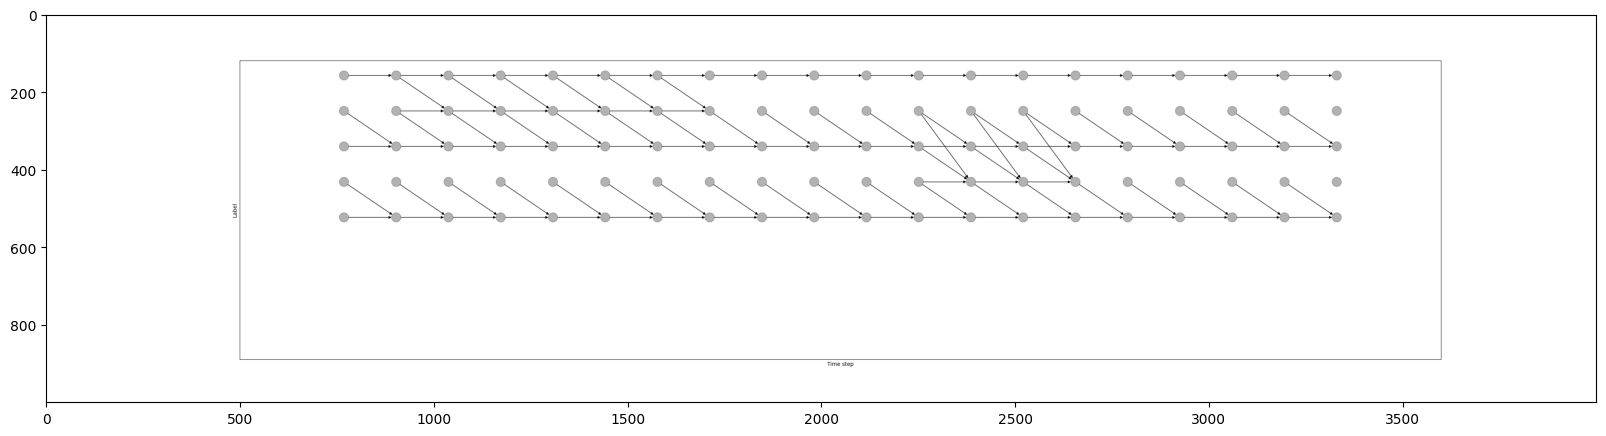

In [21]:
exportGraphFromMatrix(m_loss[0], ["1","1","8","2"], "graph.png")
fig2 = plt.figure(figsize = (20,15)) # create a 5 x 5 figure
ax3 = fig2.add_subplot(111)
ax3.imshow(plt.imread("graph.png"))